In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from random import sample
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import cross_val_score, KFold
from pandas import *
from sklearn.linear_model import LinearRegression
from scipy import stats
import seaborn as sns
import sys

from sklearn.mixture import GaussianMixture
from collections import Counter
import matplotlib.colors as mcolors
from tslearn.clustering import TimeSeriesKMeans
from sklearn.cluster import KMeans

Using TensorFlow backend.
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.cluster.k_means_ module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.cluster. Anything that cannot be imported from sklearn.cluster is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
# This is the place where your Capstone folder should be
main_path = os.getcwd()
print(main_path)

C:\Users\Max Tchibozo\Desktop\CAPSTONE\Capstone-Fall-2020


In [3]:
# I put my sp500.csv file inside a folder called data
symbols = pd.read_csv('.\data\sp500.csv')
print(symbols.head())

   Unnamed: 0 Symbol             GICS Sector
0           0    MMM             Industrials
1           1    ABT             Health Care
2           2   ABBV             Health Care
3           3   ABMD             Health Care
4           4    ACN  Information Technology


In [4]:
import glob
import pandas as pd

# get data file names - this is for windows (you might have to change the \\ to / with Linux/Mac)
path = main_path + '\\data\\stock-data\\'

filenames = glob.glob(path + "*.csv")
dfs = []
for filename in sorted(filenames):
    _=pd.read_csv(filename)
    _['Symbol']=filename.split('\\')[-1].split('.')[0] #Maxime: I updated this part with the '\\' which is for Windows. You might have to change it back!
    _['Date'] = pd.to_datetime(_.Date)
    _ = _.sort_values(by=['Date']).reset_index(drop=True)
    dfs.append(_)

df_concat = pd.concat(dfs, ignore_index=True)
df_concat.head()

,Date,Open,High,Low,Close,Adj Close,Volume,Symbol
0,1999-11-18,32.546494,35.765381,28.612303,31.473534,27.011942,62546300.0,A
1,1999-11-19,30.713520,30.758226,28.478184,28.880543,24.786524,15234100.0,A
2,1999-11-22,29.551144,31.473534,28.657009,31.473534,27.011942,6577800.0,A
3,1999-11-23,30.400572,31.205294,28.612303,28.612303,24.556314,5975600.0,A
4,1999-11-24,28.701717,29.998211,28.612303,29.372318,25.208586,4843200.0,A


In [5]:
# We adjust opening, high, low and close

bwd_window=50; fwd_window = 20;
#smoothing = 3 
df = df_concat.copy()
df.loc[df.Volume==0,['Open','High','Low','Close','Volume']]=np.nan

df['Open']  = df['Open'] /df['Close']*df['Adj Close']
df['High']  = df['High'] /df['Close']*df['Adj Close']
df['Low']   = df['Low']  /df['Close']*df['Adj Close']
df['Close'] = df['Close']/df['Close']*df['Adj Close']

df = df[['Date','Symbol','Open','High','Low','Close','Volume']]
df.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


,Date,Symbol,Open,High,Low,Close,Volume
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0
4,1999-11-24,A,24.633047,25.745754,24.556308,25.208586,4843200.0


In [6]:
for fwd_window in [5,10,20]:
    df['fwd_max_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_close'] = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Close', min_periods=fwd_window).Close.min().iloc[::-1].reset_index(name='field')['field']
    df['CPP'+str(fwd_window)] = 100*df['fwd_max_close']/df['Close']-100
    df['CPL'+str(fwd_window)] = 100*df['fwd_min_close']/df['Close']-100
    
    df['fwd_max_high']  = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='High', min_periods=fwd_window).High.max().iloc[::-1].reset_index(name='field')['field']
    df['fwd_min_low']   = df.iloc[::-1].groupby('Symbol', sort=False).rolling(fwd_window, on='Low',  min_periods=fwd_window).Low.min().iloc[::-1].reset_index(name='field')['field']
    df['PP'+str(fwd_window)] = 100*df['fwd_max_high']/df['Open']-100
    df['PL'+str(fwd_window)] = 100*df['fwd_min_low']/df['Open']-100
    df = df.drop(columns=['fwd_max_close','fwd_min_close','fwd_max_high','fwd_min_low'])

df = df[(df.Date<'2015-01-01')&(df.Date>='1990-01-01')]
df = df[~df.isnull()]
df.head(4)

,Date,Symbol,Open,High,Low,Close,Volume,CPP5,CPL5,PP5,PL5,CPP10,CPL10,PP10,PL10,CPP20,CPL20,PP20,PL20
0,1999-11-18,A,27.932802,30.695390,24.556310,27.011942,62546300.0,0.000000,-9.090896,9.890120,-12.500000,0.284105,-9.090896,9.890120,-12.500000,7.386367,-9.090896,9.890120,-12.500000
1,1999-11-19,A,26.359664,26.398033,24.441202,24.786524,15234100.0,8.978339,-0.928768,2.474531,-7.278021,10.216735,-0.928768,6.404663,-7.278021,17.027879,-0.928768,10.043676,-7.278021
2,1999-11-22,A,25.362064,27.011942,24.594679,27.011942,6577800.0,0.000000,-9.090896,6.505298,-3.177014,3.977274,-9.090896,12.405443,-3.177014,7.386367,-9.090896,14.372170,-3.177014
3,1999-11-23,A,26.091084,26.781731,24.556314,24.556314,5975600.0,5.468737,0.000000,2.647061,-5.882379,14.374984,0.000000,9.264683,-5.882379,18.124986,0.000000,11.176457,-5.882379


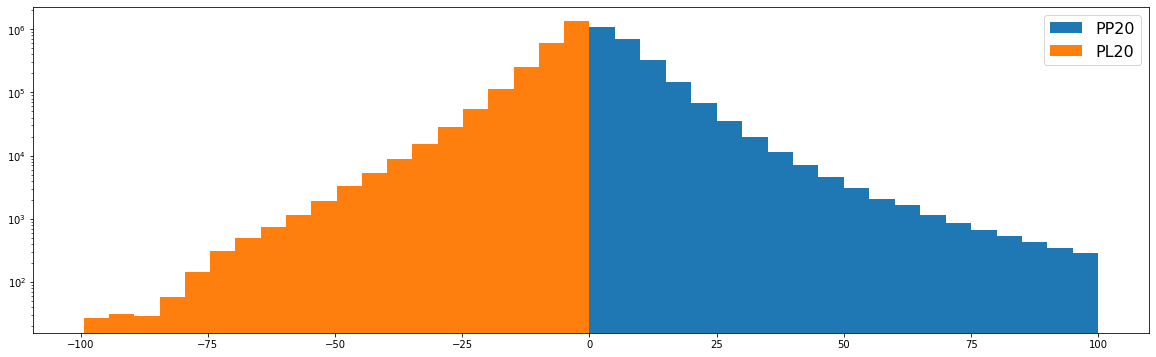

In [7]:
fs=16;
plt.figure(figsize=(20,6))
plt.hist(df.PP20[df.PP20<=100].values,20)
plt.hist(df.PL20[df.PL20<=100].values,20)
plt.yscale('log')
plt.legend(['PP20','PL20'],fontsize=fs)
plt.savefig('pp_pl_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

# symmetry of patterns

In [8]:
ind = list(df[(df['CPP20']>=10)&(df['CPP20']<=100)].index)
ind = sample(ind,len(ind))
X_data=[]; y_data=[];
s_num=50000;

for i in ind[:s_num]:
    x = df.loc[i-(bwd_window-1):i,:]['Close'].values
    s = df.loc[i-(bwd_window-1):i,:]['Symbol'].values
    y = df.loc[i-(bwd_window-1):i,:].index.values
    y = y[-1]-y[0]+1
    if np.sum(~np.isnan(x))==bwd_window and y==bwd_window and s[0]==s[-1]:
        X_data.append( (x-np.mean(x))/np.std(x) )
        y_data.append( df.loc[i,:]['CPP20'] )
        
X_data = np.array(X_data)
y_data = np.array(y_data)
print(X_data.shape, y_data.shape)

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
X_data, y_data = shuffle(X_data, y_data, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if sys.path[0] == '':


(48875, 50) (48875,)
(39100, 50) (9775, 50) (39100,) (9775,)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  app.launch_new_instance()


## This part is some Maxime code

In [9]:
# Maxime: This part is optional, you can save the numpy arrays to avoid having to run everything each time.
with open('.\data\X_train.npy', 'wb') as f:
    np.save(f, X_train)

with open('.\data\X_test.npy', 'wb') as f:
    np.save(f, X_test)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  


In [3]:
# Maxime: This is optional too: If you have saved the numpy arrays, you can load them here

with open('.\data\X_train.npy', 'rb') as f:
    X_train = np.load(f)

with open('.\data\X_test.npy', 'rb') as f:
    X_test = np.load(f)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  import sys


## Important to note: for the following algorithms: cluster mean =/= cluster centroid (at least not always).

Don't fit the cluster mean, fit the cluster center (as defined by your model/estimators - kmeans.cluster_centers_ for example).

## KMeans Clustering

In [104]:
# GMM take a while to train
n_clusters = 20
km = KMeans(n_clusters)
km.fit(X_train)
y_train_pred = km.predict(X_train)


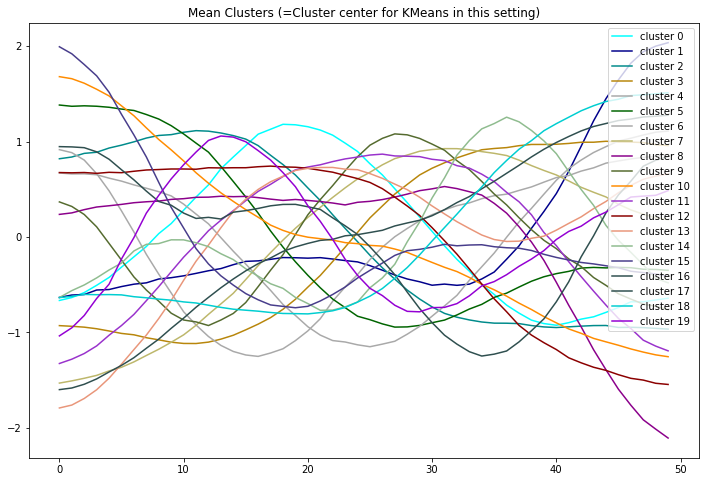

In [106]:
plt.figure(figsize=(12,8))
for k in range(n_clusters):
    cluster_indices = [i for i,x in enumerate(y_train_pred) if x == k]
    cluster_center = km.cluster_centers_[k]#np.mean(X_train[cluster_indices,:],axis=0)
    plt.plot(cluster_center,color = list(mcolors.CSS4_COLORS)[20+k],label='cluster '+str(k))
plt.legend(loc = "upper right")
plt.title('Mean Clusters (=Cluster center for KMeans in this setting)')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy 

<Figure size 1440x1440 with 0 Axes>

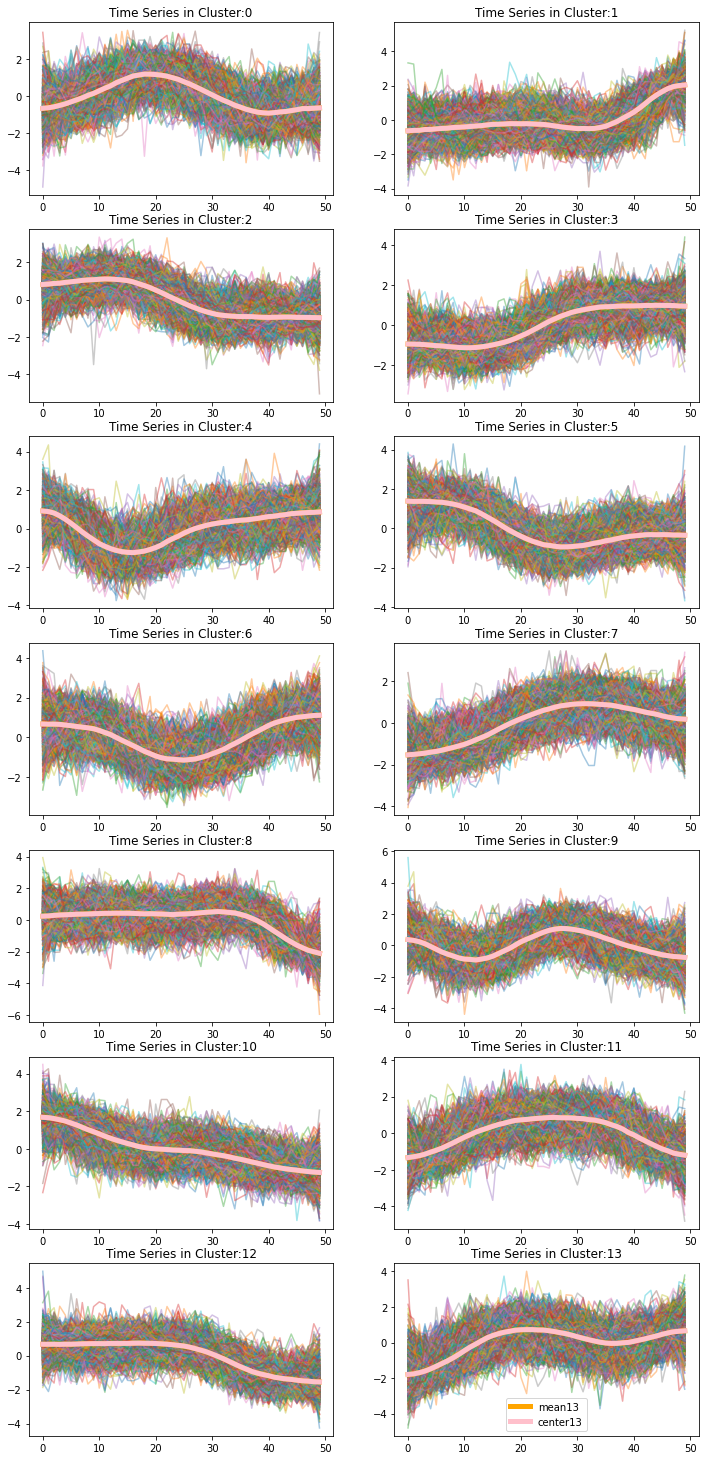

In [107]:
plt.figure(figsize=(20,20))
fig, axes = plt.subplots(7, 2,figsize=(12,26))
axes_list = list(axes.flatten())
for cluster_nb in range(14):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    cluster_mean = np.mean(X_train[indices,:],axis=0)
    cluster_center = km.cluster_centers_[cluster_nb]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Time Series in Cluster:'+str(cluster_nb))
    for i in range(len(indices)):
        ax.plot(X_train[indices[i]],alpha=0.4)
    ax.plot(cluster_mean,color='orange',linewidth=5,alpha=1,label="mean"+str(cluster_nb))
    ax.plot(cluster_center,color='pink',linewidth=5,alpha=1,label="center"+str(cluster_nb))
plt.legend()
plt.show()

Ok fine... in the case of KMeans on a regular time series, cluster center = cluster mean.

## Gaussian Mixture Models

-- just an idea

In [67]:
# GMM take a while to train
n_clusters = 20
gm = GaussianMixture(n_clusters)
gm.fit(X_train)

GaussianMixture(n_components=20)

In [68]:
# This is to see how many points there are in each cluster
y_train_pred = gm.predict(X_train)
print(y_train_pred)
print(Counter(y_train_pred)) 

[ 0 13  1 ... 16 10  2]
Counter({13: 3808, 4: 3174, 16: 2923, 2: 2703, 7: 2636, 15: 2404, 1: 2366, 3: 2174, 8: 1938, 17: 1875, 18: 1725, 19: 1710, 11: 1616, 0: 1562, 9: 1371, 5: 1270, 14: 1181, 12: 1124, 10: 1031, 6: 509})


<Figure size 864x504 with 0 Axes>

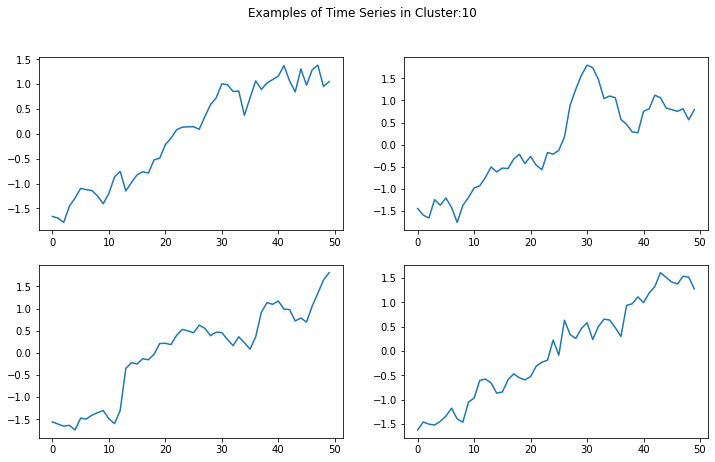

In [15]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 10
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

<Figure size 864x504 with 0 Axes>

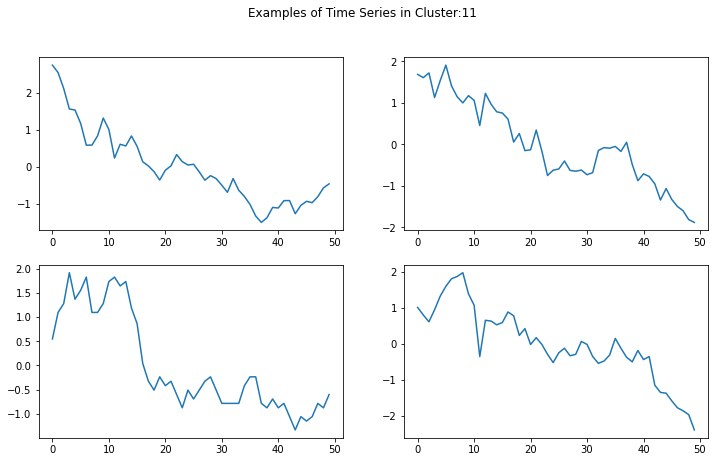

In [16]:
# We Look at the type of values that have been stored in cluster 10
cluster_nb = 11
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-pa

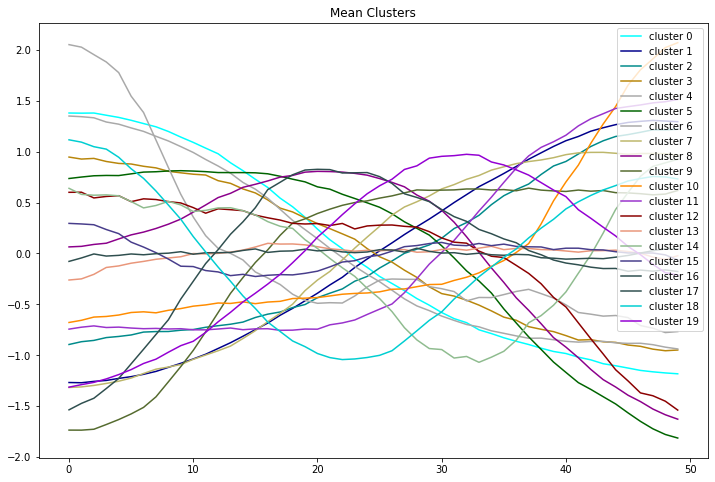

In [69]:
plt.figure(figsize=(12,8))
for k in range(n_clusters):
    cluster_indices = [i for i,x in enumerate(y_train_pred) if x == k]
    cluster_mean = np.mean(X_train[cluster_indices,:],axis=0)
    plt.plot(cluster_mean,color = list(mcolors.CSS4_COLORS)[20+k],label='cluster '+str(k))
plt.legend(loc = "upper right")
plt.title('Mean Clusters')
plt.show()

Like KMeans, GMM just seem to capture simple harmonics (sine waves). I think we can do better...

<Figure size 864x504 with 0 Axes>

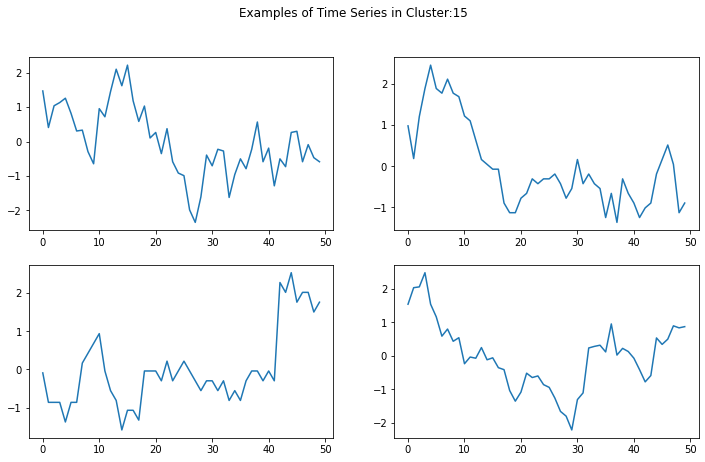

In [17]:
# We Look at the type of values that have been stored in cluster 15
cluster_nb = 15
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
plt.show()

## Dynamic Time Warping (DTW)

Quick link: https://medium.com/@shachiakyaagba_41915/dynamic-time-warping-with-time-series-1f5c05fb8950

Best way to understand is to get your hands dirty: https://tslearn.readthedocs.io/en/stable/user_guide/dtw.html

DTW is a promising approach IMO.

In [4]:
n_clusters = 40

model = TimeSeriesKMeans(n_clusters=n_clusters, metric="dtw")
model.fit(X_train[:4000])

TimeSeriesKMeans(metric='dtw', n_clusters=40)

In [5]:
warped_X_train = model.transform(X_train[:4000])

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [6]:
warped_X_train.shape # this is some kind of embedding - it does not have the initial shape (50,)

(4000, 40)

In [7]:
y_train_pred = model.predict(X_train[:4000])
#print(y_train_pred)
print(Counter(y_train_pred)) 

C:\ProgramData\Anaconda3\lib\site-packages\tslearn\utils.py:91: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


Counter({25: 189, 20: 184, 39: 179, 16: 166, 24: 153, 10: 150, 33: 135, 3: 134, 18: 123, 38: 115, 1: 111, 15: 110, 17: 109, 8: 108, 22: 104, 37: 99, 11: 98, 32: 95, 4: 94, 29: 93, 35: 92, 23: 91, 12: 88, 13: 85, 27: 84, 26: 84, 21: 84, 30: 81, 2: 80, 14: 77, 31: 75, 6: 72, 9: 66, 36: 65, 28: 63, 7: 61, 5: 56, 19: 55, 34: 52, 0: 40})


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  after removing the cwd from sys.path.


<Figure size 864x504 with 0 Axes>

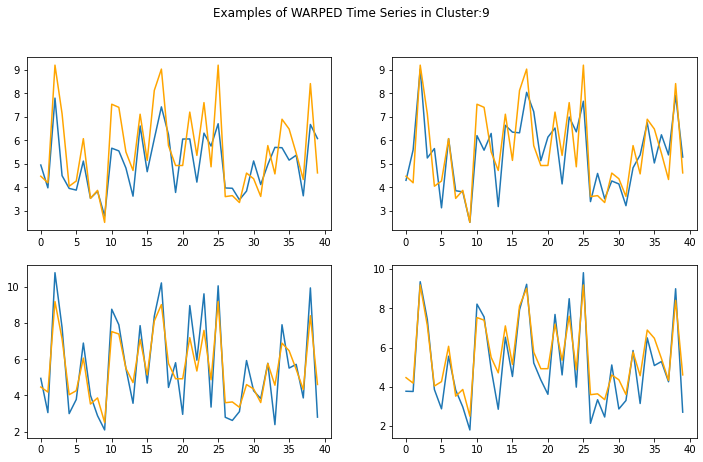

In [8]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

warped_cluster_mean = np.mean(warped_X_train[indices,:],axis=0)

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('Examples of WARPED Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(warped_X_train[indices[0]])
axes[0,0].plot(warped_cluster_mean,color='orange')

axes[0,1].plot(warped_X_train[indices[1]])
axes[0,1].plot(warped_cluster_mean,color='orange')

axes[1,0].plot(warped_X_train[indices[2]])
axes[1,0].plot(warped_cluster_mean,color='orange')

axes[1,1].plot(warped_X_train[indices[3]])
axes[1,1].plot(warped_cluster_mean,color='orange')
plt.show()

Be careful when interpreting the above curves: These are no longer the same time series as we knew them, these are DTW embeddings of the time series.

<Figure size 864x504 with 0 Axes>

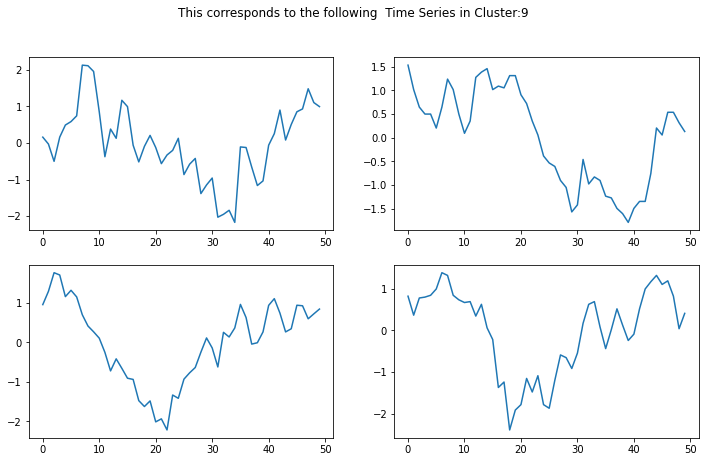

In [88]:
cluster_nb = 9
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following TRUE Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])

plt.show()

This is a good sign (Thanks Hritik!) the decreasing spike trend has been captured by this cluster, even though the spike does not happen at the same time for all time series.

Hritik's point was that once we use Dynamic Time Warping (DTW), it no longer makes sense to take of the mean of the time series within a cluster. Since the same pattern may appear in different places on different time series, they would be averaged out when computing the mean.

### Let's look at a few other clusters

<Figure size 864x504 with 0 Axes>

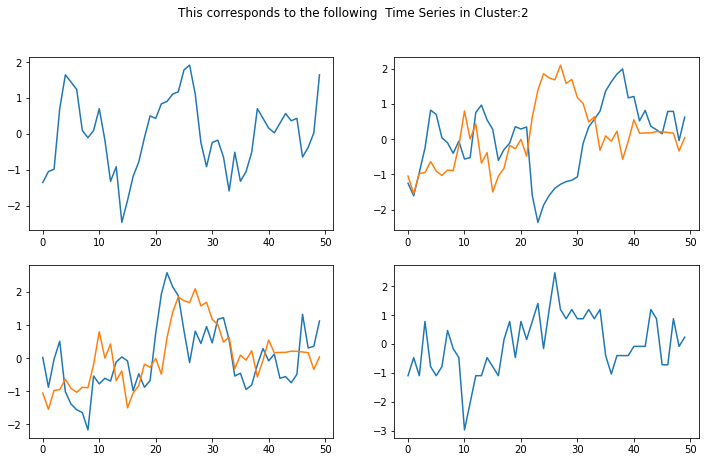

In [97]:
cluster_nb = 2
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following  Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])
#axes[0,0].plot(model.cluster_centers_[cluster_nb])

axes[0,1].plot(X_train[indices[1]])
axes[0,1].plot(model.cluster_centers_[cluster_nb])

axes[1,0].plot(X_train[indices[2]])
axes[1,0].plot(model.cluster_centers_[cluster_nb])

axes[1,1].plot(X_train[indices[3]])
#axes[1,1].plot(model.cluster_centers_[cluster_nb])

plt.show()

Here, the orange line corresponds to the cluster center. All of these time series have been assigned to the same cluster. Try shifting the orange line to the left or to the right to see if you agree these Time Series should be clustered together.

I only put the orange line for two plots, but you could do it for all of them.

<Figure size 864x504 with 0 Axes>

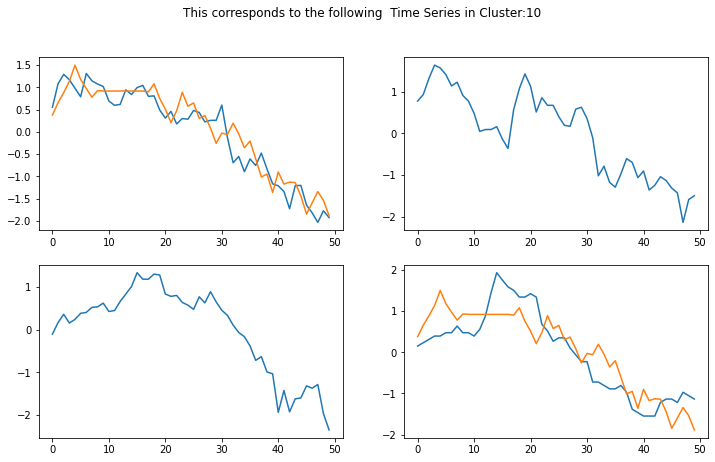

In [100]:
cluster_nb = 10
indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]

plt.figure(figsize=(12,7))
fig, axes = plt.subplots(2, 2,figsize=(12,7))
fig.suptitle('This corresponds to the following  Time Series in Cluster:'+str(cluster_nb))
axes[0,0].plot(X_train[indices[0]])
axes[0,0].plot(model.cluster_centers_[cluster_nb])

axes[0,1].plot(X_train[indices[1]])

axes[1,0].plot(X_train[indices[2]])

axes[1,1].plot(X_train[indices[3]])
axes[1,1].plot(model.cluster_centers_[cluster_nb])

plt.show()

<Figure size 1440x1440 with 0 Axes>

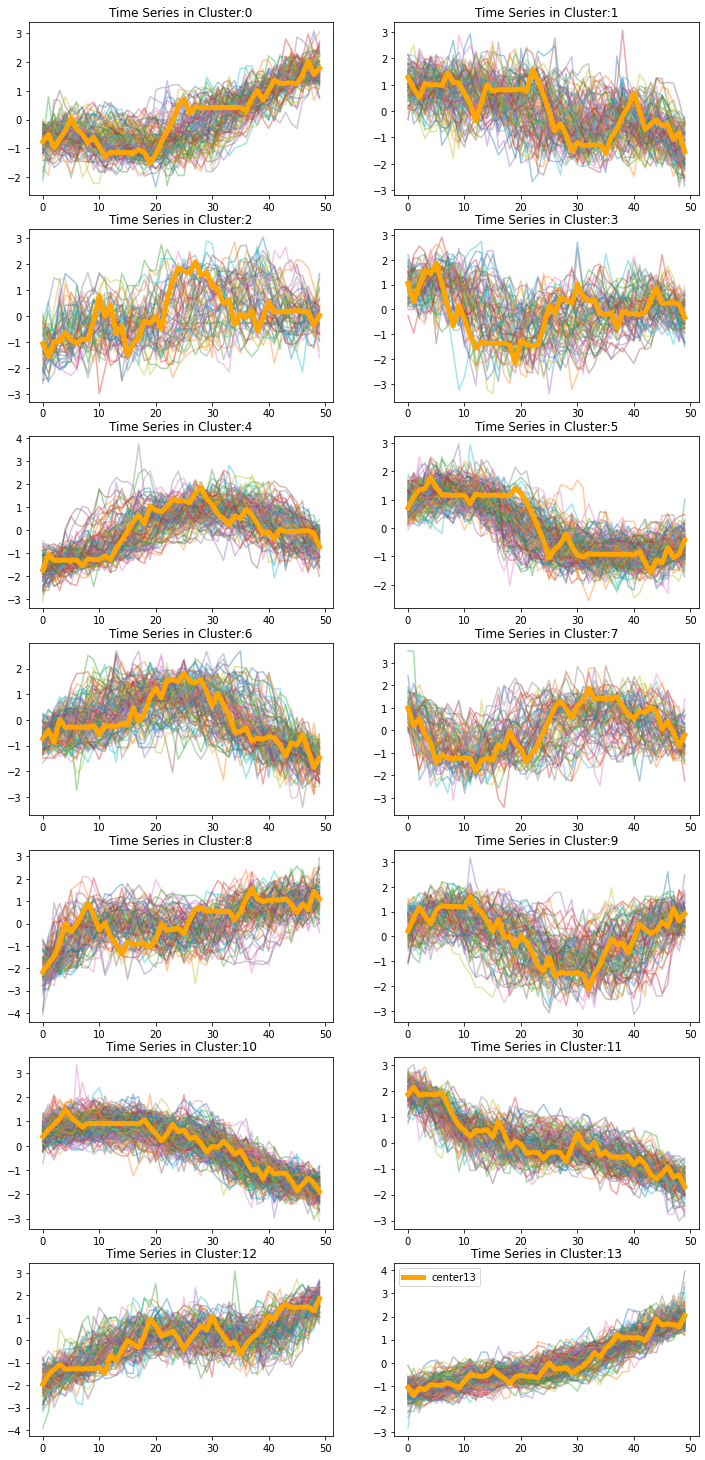

In [102]:
plt.figure(figsize=(20,20))
fig, axes = plt.subplots(7, 2,figsize=(12,26))
axes_list = list(axes.flatten())
for cluster_nb in range(14):
    indices = [i for i,x in enumerate(y_train_pred) if x == cluster_nb]
    cluster_center = model.cluster_centers_[cluster_nb]
    ax = axes_list[cluster_nb]
    ax.title.set_text('Time Series in Cluster:'+str(cluster_nb))
    for i in range(len(indices)):
        ax.plot(X_train[indices[i]],alpha=0.4)
    ax.plot(cluster_center,color='orange',linewidth=5,alpha=1,label="center"+str(cluster_nb))
plt.legend()
plt.show()

As you can see, here, cluster center is not equal to cluster mean. The cluster mean would have been a smooth average of all the points.
Here, cluster center is defined as per the DTW algorithm.

## What about a DTW embedding with GMM clustering?

In [ ]:
# TODO

# Something to think about! You can do DTW with a custom distance metric - for example if we are working with matrices, we could adapt a DTW algorithm to that type of input.

https://tslearn.readthedocs.io/en/stable/auto_examples/metrics/plot_dtw_custom_metric.html#sphx-glr-auto-examples-metrics-plot-dtw-custom-metric-py


### Signal processing approach

https://towardsdatascience.com/multiple-time-series-classification-by-using-continuous-wavelet-transformation-d29df97c0442

- Fourier Transform

- Seq2Seq

https://www.youtube.com/watch?v=VYpAodcdFfA

- Multi Scale Time Series Clustering

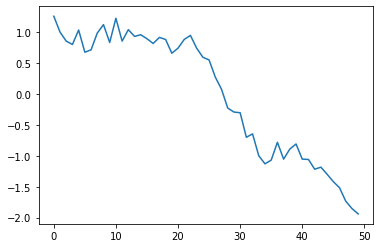

In [4]:
plt.plot(X_train[0])

### Fourier Transform

In [8]:
n

50

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # Remove the CWD from sys.path while we load stuff.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour,

<StemContainer object of 3 artists>

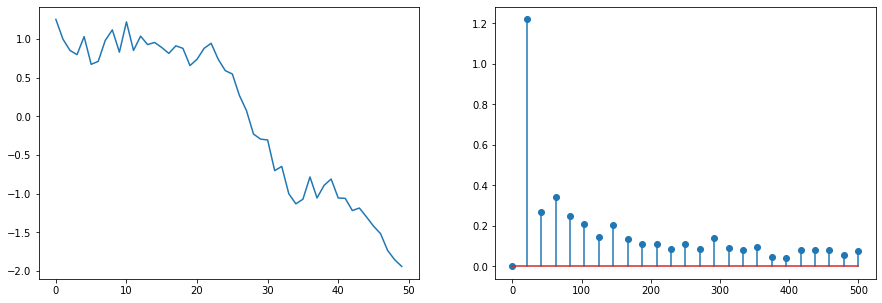

In [21]:
y = X_train[0]
# Frequency and sampling rate
Fs = 1000 # sampling rate
t = range(len(y))# Sine function

from scipy import fftpack
y_fft = fftpack.fft(y)# Plot data
n = np.size(t)
fr = Fs/2 * np.linspace(0,1,n//2)
y_m = 2/n * abs(y_fft[0:np.size(fr)])
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax[0].plot(t, y)    # plot time series
ax[1].stem(fr, y_m) # plot freq domain

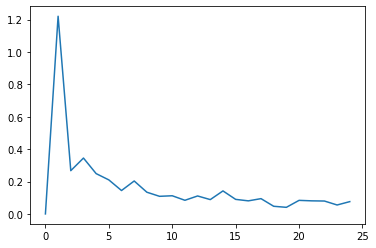

In [24]:
# Inverse FFT from freq domain to original time domainfrom scipy import fftpack
inv = fftpack.ifft(y_fft)
plt.plot(y_fft)

## This is Naftali's clustering

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

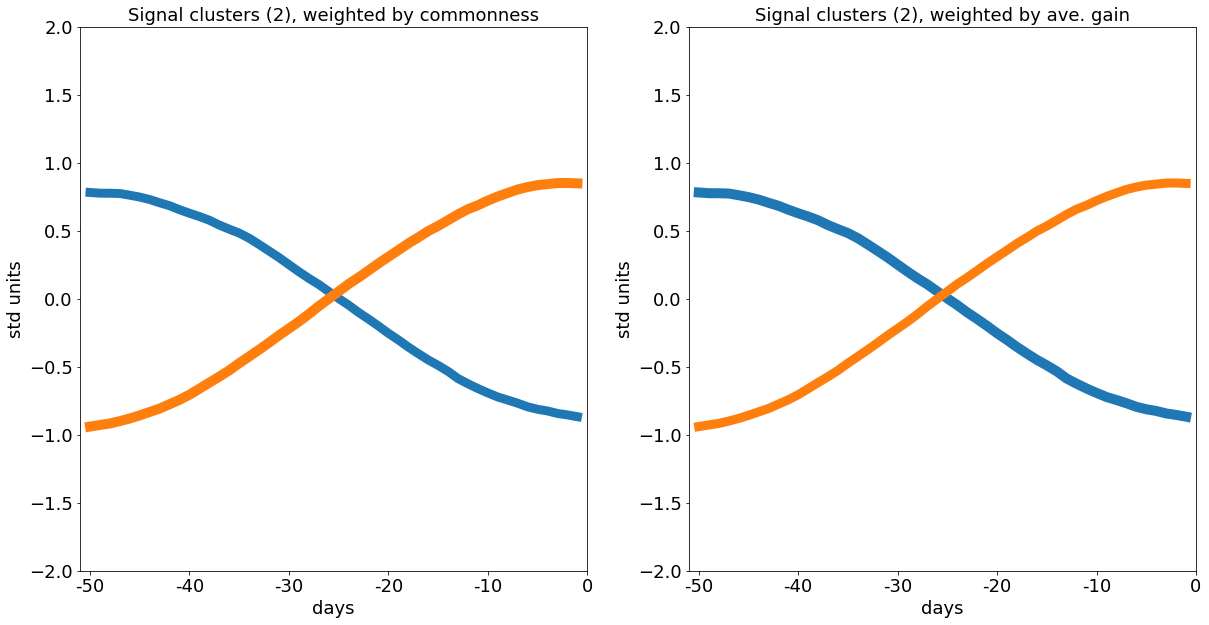

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

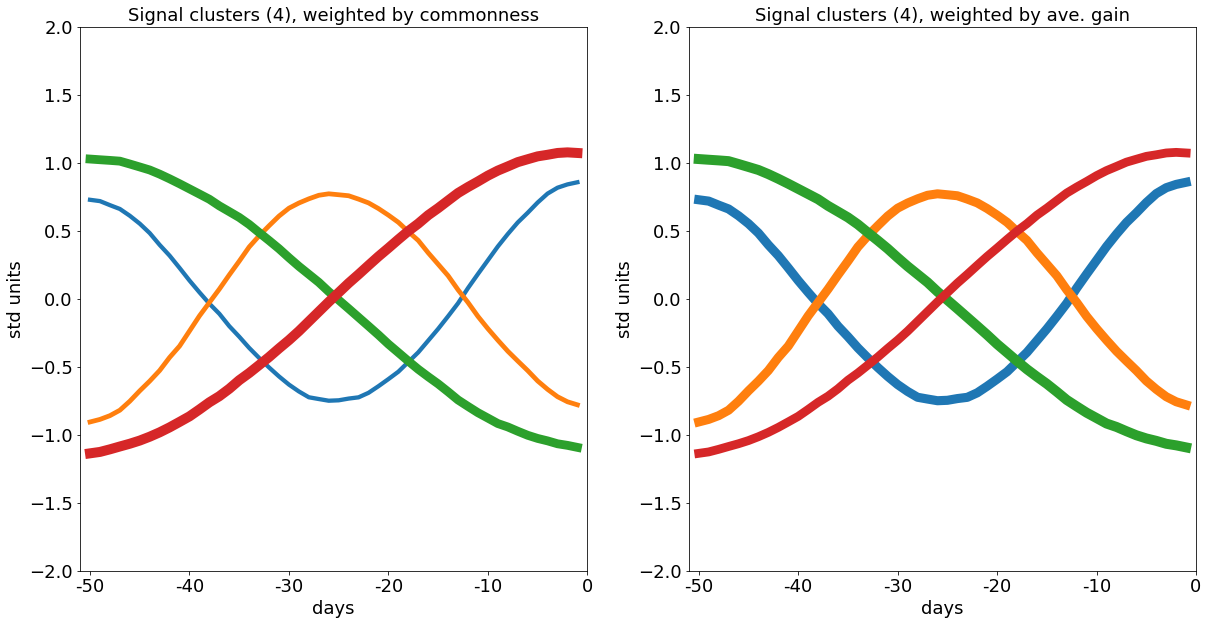

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

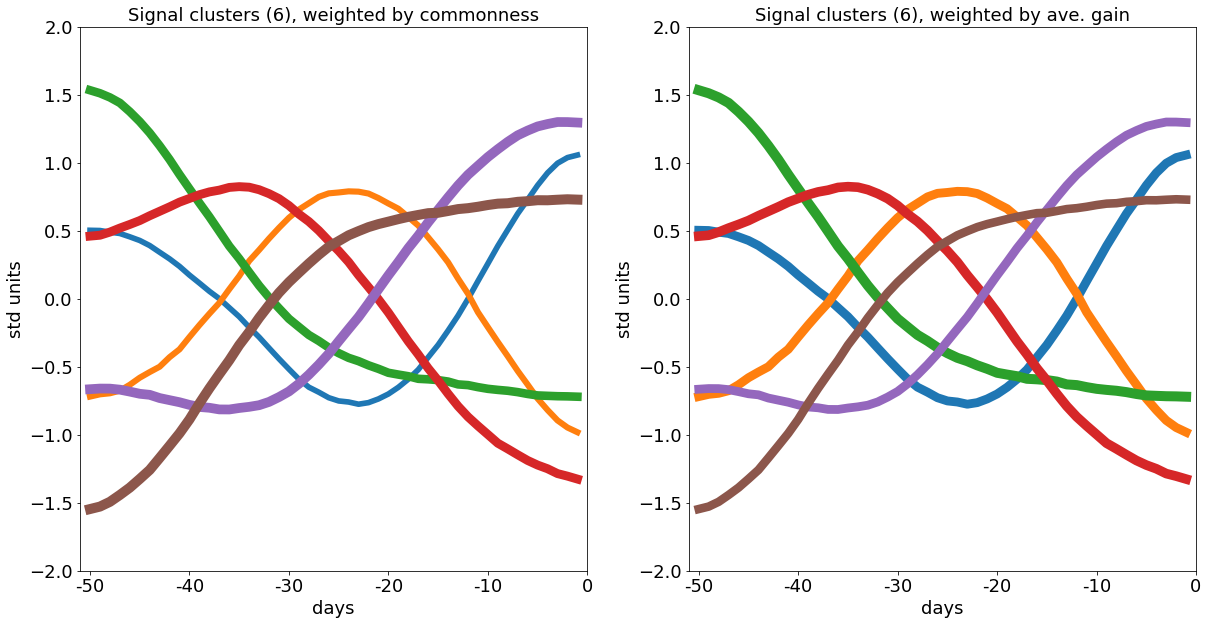

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:23: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directl

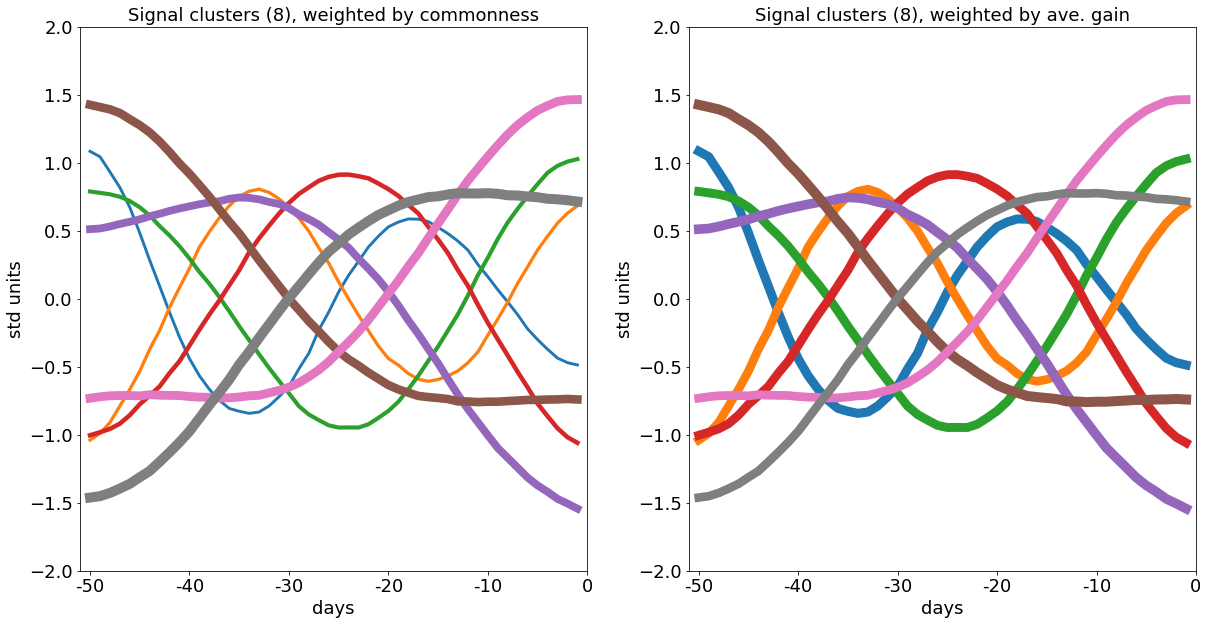

In [38]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.cluster import KMeans, SpectralClustering
cl=['#67001f','#b2182b','#d6604d','#f4a582','#fddbc7','#d1e5f0','#92c5de','#4393c3','#2166ac','#053061']
cl=['#fff7fb','#ece2f0','#d0d1e6','#a6bddb','#67a9cf','#3690c0','#02818a','#016c59','#014636'][::-1]
#https://colorbrewer2.org/#type=sequential&scheme=PuRd&n=9

for n_clusters in [2,4,6,8]:
    clu = KMeans(n_clusters=n_clusters,random_state=0)

    clu.fit( X_data ); labels1 = clu.labels_

    fs=18;
    c=[]
    plt.figure(figsize=(20,10));
    plt.subplot(121)
    w1=[]
    for i in range(n_clusters):
        w1.append( len(X_data[labels1==i])/len(X_data) )
    fact=10/max(w1)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w1[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by commonness',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.subplot(122)
    w2=[]
    for i in range(n_clusters):
        w2.append( np.mean(y_data[labels1==i]) )
    fact=10/max(w2)
    k=-1
    for i in np.argsort(w1):
        k+=1
        p=plt.plot(np.mean(X_data[labels1==i],0),linewidth=fact*w2[i] )
        c.append(p[0].get_color())
    plt.title('Signal clusters ('+str(n_clusters)+'), weighted by ave. gain',fontsize=fs)
    plt.ylabel('std units',fontsize=fs);plt.xlabel('days',fontsize=fs)
    plt.xticks(range(0,51,10),range(-50,1,10),fontsize=fs);plt.yticks(fontsize=fs)
    plt.xlim([-1,50]);plt.ylim([-2,2])

    plt.savefig('cpp_'+str(n_clusters)+'_clustered_buy_signals.png',dpi=100,bbox_inches='tight',pad_inches=.05)
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:14: MatplotlibDeprecationWarning: Setting whis to 'range' is deprecated since 3.2 and support for it will be removed two minor releases later; set it to [0, 100] to achieve the same effect.
  


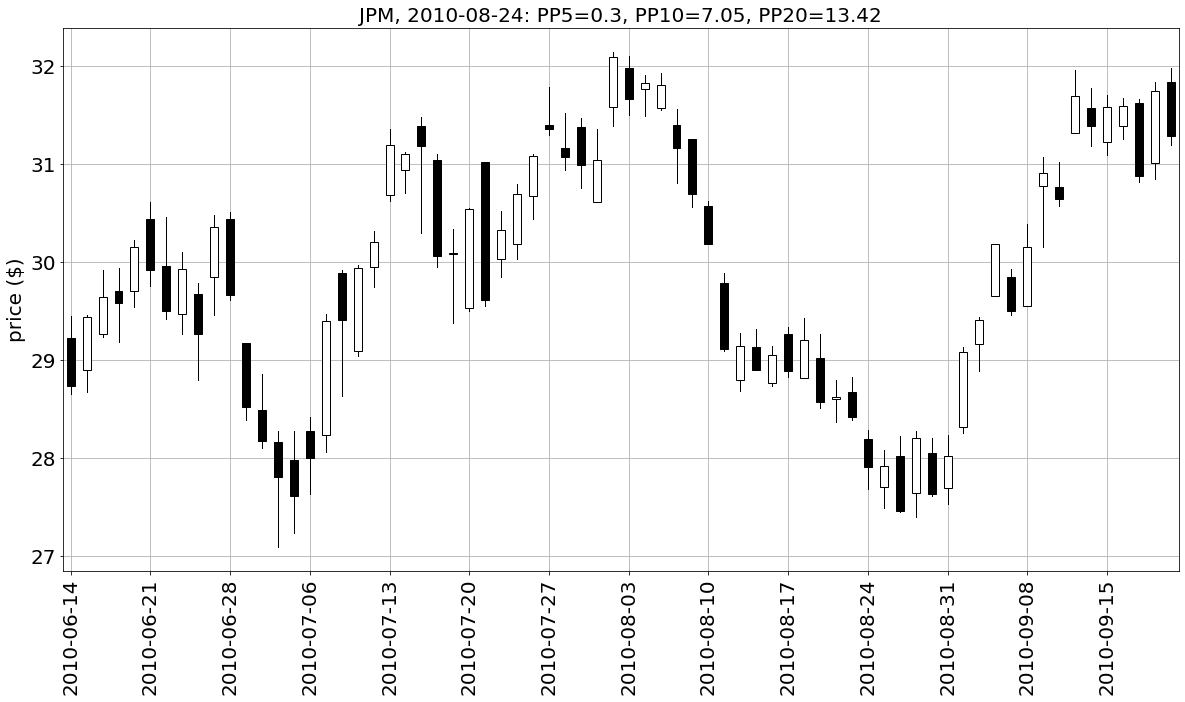

In [39]:
sym = 'JPM'
ind=list(df.loc[(df.loc[:,'Symbol']==sym) & (df.loc[:,'PP20']>10) & (df.loc[:,'Date']>'2010-01-01'),:].index.values)
ind=sample(ind,1)[0]
#ind=1178830
bwd_window=50; fwd_window = 20;
fs=20
a=df.loc[ind-bwd_window:ind+fwd_window-1,:][['Date','Open','Open','Open','High','Low','Close','Close','Close']].reset_index(drop=True)
a.Date=a.Date.astype(str)
data=np.array(a)[:,1:].T
#data=(data-np.min(np.min(data)))/(np.max(np.max(data))-np.min(np.min(data)))
xlabels=np.array(a)[:,0]
plt.figure(figsize=(20,10))
#plt.subplot(3,3,i+1)
bplot=plt.boxplot(data,showfliers=False,showcaps=False,whis='range',medianprops={'linewidth': 0},patch_artist=True,labels=xlabels)
colors=['white' if data[0,i]<data[7,i] else 'black' for i in range(data.shape[1]) ]
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
#rr=round(df.loc[ind,'RR-5'],2),round(df.loc[ind,'RR-10'],2),round(df.loc[ind,'RR-20'],2)
pp=round(df.loc[ind,'PP5'],2),round(df.loc[ind,'PP10'],2),round(df.loc[ind,'PP20'],2)
d=str(df.loc[ind,'Date']).split(' ')[0]
#ratio=round(len(z_data[y>y_threshold,0][labels==i])/len(z_data[y>y_threshold,0]),2)
title=sym+', '+d+': PP5='+str(pp[0])+', PP10='+str(pp[1])+', PP20='+str(pp[2])
plt.title(title,fontsize=fs)
plt.ylabel('price ($)',fontsize=fs)
plt.xticks(range(1,len(xlabels)+1)[::5],xlabels[::5],fontsize=fs)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs)
plt.xticks(rotation=90)
plt.grid('on')
plt.savefig('pp_example.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in greater
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in greater
  # This is added back by InteractiveShellApp.init_path()
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


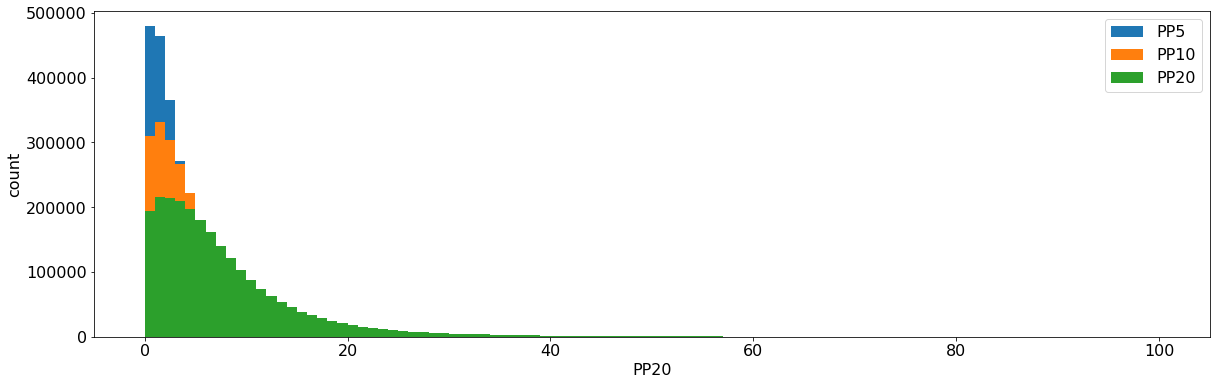

In [40]:
fs=16
plt.figure(figsize=(20,6))

x = df['PP5'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP10'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
x = df['PP20'].values
x = x[(x>0)&(x<100)]
plt.hist(x,100)
plt.xticks(fontsize=fs);plt.yticks(fontsize=fs);
plt.xlabel('PP20',fontsize=fs)
plt.ylabel('count',fontsize=fs)
plt.legend(['PP5','PP10','PP20'],fontsize=fs)
plt.savefig('pp_hist.png',dpi=100,bbox_inches='tight',pad_inches=.05)
plt.show()